# 04-1 로지스틱 회귀

## 럭키백의 확률

"k-최근접 이웃은 주변 이웃을 찾아주니까 이웃의 클래스 비율을 확률이라고 출력하면 되지 않을까?"

### 데이터 준비하기

In [1]:
import pandas as pd
fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


어떤 종류의 생선이 있는지 Species 열에서 고유한 값 추출

In [2]:
pd.unique(fish['Species'])

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

Species 열을 타깃으로 만들고 나머지 5개 열으느 입력 데이터로 사용하겠습니다.

In [3]:
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()

In [4]:
fish_input[:5]

array([[242.    ,  25.4   ,  30.    ,  11.52  ,   4.02  ],
       [290.    ,  26.3   ,  31.2   ,  12.48  ,   4.3056],
       [340.    ,  26.5   ,  31.1   ,  12.3778,   4.6961],
       [363.    ,  29.    ,  33.5   ,  12.73  ,   4.4555],
       [430.    ,  29.    ,  34.    ,  12.444 ,   5.134 ]])

In [5]:
fish_target = fish['Species'].to_numpy()

이제 훈련 세트와 테스트 세트로 나누겠습니다.

In [6]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

사이킷런의 StandardScaler 클래스를 사용해 훈련 세트와 테스트 세트를 표준화 전처리하겠습니다.

In [7]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### k-최근접 이웃 분류기의 확률 예측

KNeighborsClassifier 클래스 객체를 만들고 훈련 세트로 모델을 훈련한 다음 훈련 세트와 테스트 세트의 점수를 확인해 보겠습니다. 최근접 이웃 개수인 k를 3으로 지정하여 사용합니다.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)
print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


타깃 데이터에 2개 이상의 클래스가 포함된 문제를 다중 분류multiclass classification라고 부릅니다.

다중 분류에서도 타깃값을 숫자로 바꾸어 입력할 수 있지만 사이킷런에서는 편리하게도 문자열로 된 타깃값을 그대로 사용할 수 있습니다.

이때 주의할 점이 하나 있습니다. 타깃값을 그대로 사이킷런 모델에 전달하면 순서가 자동으로 알파벳 순으로 매겨집니다.

In [9]:
kn.classes_

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

In [10]:
kn.predict(test_scaled[:5])

array(['Perch', 'Smelt', 'Pike', 'Perch', 'Perch'], dtype=object)

사이킷런의 분류 모델은 predict_proba() 메서드로 클래스별 확률값을 반환합니다. 테스트 세트에 있는 처음 5개의 샘플에 대한 확률을 출력해 보죠.

In [11]:
import numpy as np
proba = kn.predict_proba(test_scaled[:5])
np.round(proba, decimals=4)

array([[0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.6667, 0.    , 0.3333, 0.    , 0.    ],
       [0.    , 0.    , 0.6667, 0.    , 0.3333, 0.    , 0.    ]])

predict_proba() 메서드의 출력 순서는 앞서 보았던 classes_ 속성과 같습니다. 즉 첫 번째 열이 'Bream'에 대한 확률, 두 번재 열이 'Parkki'에 대한 확률입니다.

이 모델이 계산한 확률이 가장 가까운 이웃의 비율이 맞는지 확인해보죠.

In [12]:
distances, indexes = kn.kneighbors(test_scaled[3:4])
train_target[indexes]

array([['Roach', 'Perch', 'Perch']], dtype=object)

앞서 출력한 샘플의 클래스 확률과 같습니다.

그런데, 3개의 최근접 이웃을 사용하기 때문에 가능한 확률은 0/3, 1/3, 2/3, 3/3이 전부겠군요. 만약 럭키백의 확률을 이렇게만 표시한다면 마케팅 팀이 만족하지 않을 것 같습니다.

## 로지스틱 회귀

이름은 회귀이지만 분류 모델입니다.

```z = a × (Weight) + b × (Length) + c × (Diagonal) + d × (Height) + e × (Width) + f```

z는 어떤 값도 가능합니다. 하지만 확률이 되려면 0~1 사이 값이 되어야 합니다. z가 아주 큰 음수일 때 0이 되고,, z가 아주 큰 양수일 때 1이 되도록 바꾸는 방법은 없을까요? 시그모이드 함수sigmoid function(또는 로지스틱 함수logistic function)를 사용하면 가능합니다.

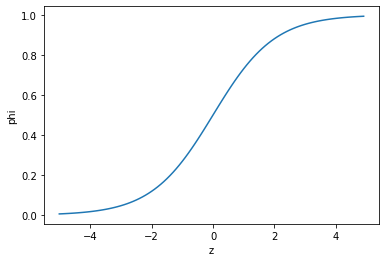

In [13]:
import numpy as np
import matplotlib.pyplot as plt
z = np.arange(-5, 5, 0.1)
phi = 1 / (1 + np.exp(-z))
plt.plot(z, phi)
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

시그모이드 함수의 출력은 정말 0에서 1까지 변하는군요.

### 로지스틱 회귀로 이진 분류 수행하기

넘파이 배열은 True, False 값을 전달하여 행을 선택할 수 있습니다. 이를 불리언 인덱싱boolean indexing이라고 합니다.

In [14]:
char_arr = np.array(['A', 'B', 'C', 'D', 'E'])
char_arr[[True, False, True, False, False]]

array(['A', 'C'], dtype='<U1')

이와 같은 방식을 사용해 훈련 세트에서 도미(Bream)와 빙어(Smelt)의 행만 골라내겠습니다.

In [15]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

이제 이 데이터로 로지스틱 회귀 모델을 훈련해 보겠습니다.

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

LogisticRegression()

훈련한 모델을 사용해 train_bream_smelt에 있는 처음 5개 샘플을 예측해 보죠.

In [17]:
lr.predict(train_bream_smelt[:5])

array(['Bream', 'Smelt', 'Bream', 'Bream', 'Bream'], dtype=object)

In [18]:
lr.predict_proba(train_bream_smelt[:5])

array([[0.99759855, 0.00240145],
       [0.02735183, 0.97264817],
       [0.99486072, 0.00513928],
       [0.98584202, 0.01415798],
       [0.99767269, 0.00232731]])

In [19]:
lr.classes_

array(['Bream', 'Smelt'], dtype=object)

로지스틱 회귀로 성공적인 이진 분류를 수행했군요! 그럼 선형 회귀에서처럼 로지스틱 회귀가 학습한 계수를 확인해 보죠.

In [20]:
lr.coef_, lr.intercept_

(array([[-0.4037798 , -0.57620209, -0.66280298, -1.01290277, -0.73168947]]),
 array([-2.16155132]))

train_bream_smelt의 처음 5개 샘플의 z값을 출력해보죠.

In [21]:
decisions = lr.decision_function(train_bream_smelt[:5])
decisions

array([-6.02927744,  3.57123907, -5.26568906, -4.24321775, -6.0607117 ])

이 z값을 시그모이드 함수에 통과시키면 확률을 얻을 수 있습니다.

In [22]:
from scipy.special import expit
expit(decisions)

array([0.00240145, 0.97264817, 0.00513928, 0.01415798, 0.00232731])

predict_proba() 메서드 출력의 두 번째 열의 값과 동일합니다. 즉 decision_function() 메서드는 양성 클래스에 대한 z 값을 반환합니다.

이진 분류의 경우 predict_proba() 메서드는 음성 클래스와 양성 클래스에 대한 확률을 출력합니다. 또 decision_function() 메서드는 양성 클래스에 대한 z 값을 계산합니다. 또 coef_ 속성과 intercept_ 속성에는 로지스틱 모델이 학습한 선형 방정식의 계수가 들어있습니다.

이제 이진 분류의 경험을 바탕으로 7개의 생선을 분류하는 다중 분류 문제로 넘어가 보겠습니다.

### 로지스틱 회귀로 다중 분류 수행하기

LogisticRegression 클래스를 사용해 7개의 생선을 분류해 보면서 이진 분류와의 차이점을 알아보겠습니다.

LogisticRegression 클래스는 기본적으로 반복적인 알고리즘을 사용합니다. max_iter 매개변수에서 반복 횟수를 지정하며 기본값은 100입니다. 여기에 준비한 데이터셋을 사용해 모델을 훈련하면 반복 횟수가 부족하다는 경고가 발생합니다. 충분하게 훈련시키기 위해 반복 횟수를 1000으로 늘리겠습니다.

또 LogisticRegression은 기본적으로 릿지 회귀와 같이 계수의 제곱을 규제합니다. 이런 규제를 L2 규제라고도 부릅니다. LogisticRegression에서 규제를 제어하는 매개변수는 C입니다. 하지만 C는 alpha와 반대로 작을수록 규제가 커집니다. C의 기본값은 1입니다. 여기에서는 규제를 조금 완화하기 위해 20으로 늘리겠습니다.

다음 코드는 LogisticRegression 클래스로 다중 분류 모델을 훈련하는 코드입니다.

In [23]:
lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


훈련 세트와 테스트 세트에 대한 점수가 높고 과대적합이나 과소적합으로 치우친 것 같지 않습니다. 그럼 테스트 세트의 처음 5개 샘플에 대한 예측을 출력해보죠.

In [24]:
lr.predict(test_scaled[:5])

array(['Perch', 'Smelt', 'Pike', 'Roach', 'Perch'], dtype=object)

이번에는 테스트 세트의 처음 5개 샘플에 대한 예측 확률을 출력해 보겠습니다.

In [25]:
proba = lr.predict_proba(test_scaled[:5])
np.round(proba, decimals=3)

array([[0.   , 0.014, 0.841, 0.   , 0.136, 0.007, 0.003],
       [0.   , 0.003, 0.044, 0.   , 0.007, 0.946, 0.   ],
       [0.   , 0.   , 0.034, 0.935, 0.015, 0.016, 0.   ],
       [0.011, 0.034, 0.306, 0.007, 0.567, 0.   , 0.076],
       [0.   , 0.   , 0.904, 0.002, 0.089, 0.002, 0.001]])

In [26]:
lr.classes_

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

첫 번재 샘플은 Perch를 가장 높은 확률로 예측했습니다.

그럼 다중 분류일 경우 선형 방정식은 어떤 모습일까요? coef_와 intercept_의 크기를 출력해 보겠습니다.

In [27]:
lr.coef_.shape, lr.intercept_.shape

((7, 5), (7,))

이 데이터는 5개의 특성을 사용하므로 coef_ 배열의 열은 5개입니다. 그런데 행이 7이군요. intercept_도 7개나 있습니다. 이 말은 이진 분류에서 보았던 z를 7개나 계산한다는 의미입니다. 다중 분류는 클래스마다 z 값을 하나씩 계산합니다. 당연히 가장 높은 z 값을 출력하는 클래스가 예측 클래스가 됩니다. 확률은? 이진 분류에서는 시그모이드 함수를 사용했습니다. 다중 분류는 이와 달리 소프트맥스softmax 함수를 사용하여 7개의 z 값을 확률로 변환합니다.

이진 분류에서처럼 decision_function() 메서드로 z1~ z7까지의 값을 구한 다음 소프트맥스 함수를 사용해 확률로 바꾸어 보겠습니다. 먼저 테스트 세트의 처음 5개 샘플에 대한 z1~z7의 값을 구해 보죠.

In [29]:
decision = lr.decision_function(test_scaled[:5])
np.round(decision, decimals=2)

array([[ -6.5 ,   1.03,   5.16,  -2.73,   3.34,   0.33,  -0.63],
       [-10.86,   1.93,   4.77,  -2.4 ,   2.98,   7.84,  -4.26],
       [ -4.34,  -6.23,   3.17,   6.49,   2.36,   2.42,  -3.87],
       [ -0.68,   0.45,   2.65,  -1.19,   3.26,  -5.75,   1.26],
       [ -6.4 ,  -1.99,   5.82,  -0.11,   3.5 ,  -0.11,  -0.71]])

사이파이는 소프트맥스 함수도 제공합니다.

In [30]:
from scipy.special import softmax
proba = softmax(decision, axis=1)
np.round(proba, decimals=3)

array([[0.   , 0.014, 0.841, 0.   , 0.136, 0.007, 0.003],
       [0.   , 0.003, 0.044, 0.   , 0.007, 0.946, 0.   ],
       [0.   , 0.   , 0.034, 0.935, 0.015, 0.016, 0.   ],
       [0.011, 0.034, 0.306, 0.007, 0.567, 0.   , 0.076],
       [0.   , 0.   , 0.904, 0.002, 0.089, 0.002, 0.001]])

앞서구한 decision 배열을 softmax() 함수에 전달했습니다. softmax()의 axis 매개변수는 소프트맥스를 계산할 축을 지정합니다. 여기에서는 axis=1로 지정하여 각 행, 즉 각 샘플에 대해 소프트맥스를 계산합니다. 만약 axis 매개변수를 지정하지 않으면 배열 전체에 대해 소프트맥스를 계산합니다.

출력 결과를 앞서 구한 proba 배열과 비교해 보세요. 결과가 정확히 일치하는군요! 혼공머신은 로지스틱 회귀를 사용해 7개의 생선에 대한 확률을 예측하는 모델을 훈련했습니다.

## 마무리

### 핵심 포인트

- **로지스틱 회귀**: 선형 방정식을 사용한 분류 알고리즘. 선형 회귀와 달리 시그모이드 함수나 소프트맥스 함수를 사용해 클래스 확률 출력
- **다중 분류**: 타깃 클래스가 2개 이상인 분류 문제
- **시그모이드 함수**: 선형 방정식의 출력을 0과 1 사이의 값으로 압축
- **소프트맥스 함수**: 다중 분류에서 여러 선형 방정식의 출력 결과를 정규화하여 합이 1이 되도록 만듦

### 핵심 패키지와 함수

#### scikit-learn
- **LogisticRegression**: 선형 분류 알고리즘인 로지스틱 회귀를 위한 클래스
  solver 매개변수에서 사용할 알고리즘을 선택할 수 있습니다. 기본값은 'lbfgs'. 사이킷런 0.17 버전에 추가된 'sag'는 확률적 평균 경사 하강법 알고리즘으로 특성과 샘플 수가 많을 때 성능은 빠르고 좋습니다. 사이킷런 0.19 버전에는 'sag'의 개선 버전인 'saga'가 추가됨  
  penalty 매개변수에서 L2 규제(릿지 방식)와 L1 규제(라쏘 방식)를 선택할 수 있다. 기본값은 L2 규제를 의미하는 'l2'
  C 매개변수에서 규제의 강도 제어. 기본값 1.0. 값이 작을수록 규제 강해짐
- **predict_proba()**: 예측 확률 반환.
  이진 분류의 경우 샘플마다 음성 클래스와 양성 클래스에 대한 확률 반환
  다중 분류의 경우 샘플마다 모든 클래스에 대한 확률 반환
- **decision_function()**: 모델이 학습한 선형 방정식의 출력 반환
  이진 분류의 경우 양성 클래스의 확률이 반환됨. 이 값이 0보다 크면 양성 클래스, 작거나 같으면 음성 클래스.
  다중 분류의 경우 각 클래스마다 선형 방정식 계산. 가장 큰 값의 클래스가 예측 클래스가 됨